In [1]:
#Import module
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import scipy.optimize as optimization  
import pandas as pd
#Latex font
import matplotlib as mpl
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=16)

In [2]:
ls

2022_Feb_week4_Weighted_mean_calculation_Beuermann_2011_combined.out
2022_Mar_week2_Weighted_mean_calculation_Beuermann_2011_combined.txt
DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_K.ipynb
DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_K1.pdf
DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_K2.pdf
DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_P.ipynb
DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_P1.pdf
DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_P2.pdf
DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_c.ipynb
DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_c1.pdf
DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_c2.pdf
DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_e.ipynb
DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_e1.pdf
DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_e2.pdf
DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_m.ipynb
DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_m1.pdf
DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_m2.pdf
DP_Leo_LTT_fit_In

In [3]:
#Read data ---#1
#Input = "2022_Mar_week2_Weighted_mean_calculation_Beuermann_2011_combined.txt"
Input = "2022_Feb_week4_Weighted_mean_calculation_Beuermann_2011_combined.out"
Data   = np.genfromtxt(Input)

BJD_time = Data[:,0]
OC = Data[:,1]
OC_err = Data[:,2]

In [4]:
#Linear phemeris equation(From equation 1) convert from TT to TDB
#New ephemeris
#BJD0 = 2448773.21461 - 2400000
#P0 = 0.0623628426

#Schwope_2002
BJD0 = 2448773.215071 - 2400000
dBJD0 = 0.000018
P0 = 0.06236283691
dP0 = 0.00000000070

In [5]:
#t = T0_bjd + P0_day*Epoch
x = BJD_time
y = OC
dy = OC_err

len_x = len(x)
#print(len_x)
#print(x)

In [6]:
m = 0
c = 0
K = 33.7       #m/s
P = 10220       #days
e = 0.39               #No-unit
w = -1.36           #rad
tau = 53025   #days

In [7]:
from scipy.optimize import fsolve
from scipy.optimize import curve_fit

In [8]:
def TAno(P,tau,e,t):
    MAno = 2*np.pi/P*((t-tau)%P)
    EFunc = lambda x: x-e*np.sin(x)-MAno
    EAno = fsolve(EFunc, MAno)
    f = np.arccos((np.cos(EAno)-e)/(1-e*np.cos(EAno)))
    f = np.where(EAno>np.pi,-f,f)
    return f

In [9]:
def keplerian_fit(t,m,c,K,P,e,w,tau):
    f = TAno(P,tau,e,t)
    Epoch = (t-BJD0)/P0
    return m*Epoch + c + K*((1-e*e)/(1+e*np.cos(f))*np.sin(f+w))

In [10]:
import scipy.optimize as optimization  
guess = (m,c,K,P,e,w,tau)
params, params_covariance = optimization.curve_fit(keplerian_fit, x, y,sigma=dy, absolute_sigma=False,p0=guess)

In [11]:
m = params[0]
c = params[1]
K = params[2]
P = params[3]
e = params[4]
w = params[5]
tau = params[6]


dm = params_covariance[0,0]
dc = params_covariance[1,1]
dK = params_covariance[2,2]
dP = params_covariance[3,3]
de = params_covariance[4,4]
dw = params_covariance[5,5]
dtau = params_covariance[6,6]


ocfit = keplerian_fit(x,m,c,K,P,e,w,tau)
#print(ocfit)


if e<0:
    w -= np.pi
    e *= -1
    w_deg = w*180/np.pi
#    print(K,P,e,w,w_deg,tau)


#Semi-major axis calculation
P_yr = P/365.25              # period in years
a_au = (P_yr**2)**(1./3)     # semi-major axis in au
#print(a_au)
da_au = (2/3)*((P/365.35)**(-1./3))*((dP**0.5)/365.25)
#print(da_au)

#Semi-amplitude calculation
K_auyr = K*2.1096256684e-4
#print(K_auyr)
    
mp = (2*np.pi)**(-1)*K_auyr*np.sqrt(1-e**2)*(2*P_yr)**(1/3)
mp_mjup = mp*1047.59421
#print(mp_mjup)
dmp_mjup = mp_mjup * np.sqrt((dK/K)**2 + ((dP/365.25)/(3*(P/365.25)))**2 + (e*de/np.sqrt(1-e*e))**2 )
#print(dmp_mjup)

##T
T = c/(24*60*60) + BJD0 + 2400000
dT = np.sqrt((((dc**(0.5))/(24*60*60))**2) + (dBJD0**2))
#T = BJD0
#print(T)
#print(dT)

##P
Period = (m/(24*60*60)) + P0
dPeriod = np.sqrt((((dm**(0.5))/(24*60*60))**2) + (dP0**2))
#print(P)
#print(dP)

sinic_ac = K*3*(10**8)*(10**2)
print(sinic_ac)
dsinic_ac = np.sqrt((dK**0.5)**2)*3*(10**8)*(10**2)
print(dsinic_ac)

print("The Keplerian parameters:")
print("dP =", m, "+/-", dm**0.5, "[s]")
print("dT0 =", c, "+/-", dc**0.5, "[s]")
print("T0 =", T, "+/-", dT, "[days]")
print("P_bin =", Period, "+/-", dPeriod, "[days]")
print("K =", K, "+/-", dK**0.5, "[s]")
print("P_d =", P, "+/-", dP**0.5, "[days]")
print("P_yr =", P/365.25, "+/-", (dP**0.5)/365.25, "[years]")
print("e =", e, "+/-", de**0.5, "[-]")
print("w =", w, "+/-", dw**0.5, "[rad]")
print("w_deg =", w*(180/np.pi), "+/-", dw**0.5*(180/np.pi), "[deg]")
print("tau =", tau, "+/-", dtau**0.5, "[days]")
print("Semi-major axis sinic_ac =", sinic_ac, "+/-", dsinic_ac, "[cm]")
print ('a =', a_au ,'+/-', da_au, '[AU]')
#print ('Mpsin(i)=', mp_mjup ,'+/-', dmp_mjup, '[MJ]')

1387110936726.3916
32108446961.226982
The Keplerian parameters:
dP = 0.0003033322646783796 +/- 2.1488132040842143e-05 [s]
dT0 = 2.3894443740629105 +/- 4.68859696918169 [s]
T0 = 2448773.215098656 +/- 5.717356956858592e-05 [days]
P_bin = 0.0623628404207901 +/- 7.428689604508915e-10 [days]
K = 46.23703122421305 +/- 1.0702815653742326 [s]
P_d = 12722.064631386242 +/- 349.05707024142447 [days]
P_yr = 34.83111466498629 +/- 0.9556661745145092 [years]
e = 0.17902005300463214 +/- 0.057516843064555186 [-]
w = -1.8719901865223876 +/- 0.29429795558443866 [rad]
w_deg = -107.25713697764057 +/- 16.862030774316892 [deg]
tau = 52543.67457462914 +/- 576.273189691739 [days]
Semi-major axis sinic_ac = 1387110936726.3916 +/- 32108446961.226982 [cm]
a = 10.665427028004077 +/- 0.1951036796344091 [AU]


In [12]:
x_min, x_max = np.amin(x), np.amax(x)
x_line = np.linspace(x_min, x_max)
y_line = keplerian_fit(x_line, *params) #### For all interporation 
print(y_line)
#print(ocfit)
#print(x)

#Reduced_chisqrt
n = 7
dof = len_x - n
Chi_sqr = ((y - ocfit)**2/(dy)**2)/dof
Reduced_chisq = sum(Chi_sqr)
print("Reduced_chisq:",Reduced_chisq)

[  7.5942968   14.35526752  20.62963512  26.36543002  31.51832955
  36.05048455  39.92960922  43.12831715  45.62369152  47.3970853
  48.43415686  48.72515779  48.26550229  47.05666092  45.10743574
  42.43568546  39.07057617  35.05542612  30.45117927  25.34046059
  19.83200447  14.0649707    8.21224456   2.48128767  -2.88938601
  -7.64014374 -11.50782952 -14.25021129 -15.67342475 -15.65592333
 -14.16216753 -11.24226453  -7.01863107  -1.66472308   4.61795497
  11.61977427  19.137532    26.98343859  34.98953867  43.00892161
  50.91495507  58.59947192  65.97053217  72.95013513  79.47208665
  85.48011791  90.92628961  95.76968201  99.97535697 103.51357408]
Reduced_chisq: 0.10946976889215795


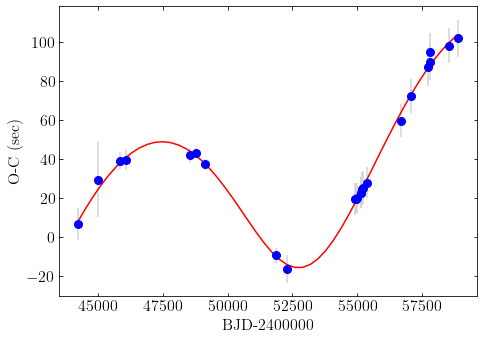

In [13]:
N_BMJD = 2400000
#print(phase)
#fig,ax = plt.subplots()
fig=plt.figure(figsize=(7, 5), tight_layout=True)
plt.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')
#plt.errorbar(x,y,dy,fmt='ok')
plt.errorbar(x, y, yerr= dy, fmt='o', markersize=8, color='blue', ecolor='lightgray')
plt.plot(x_line,y_line,'-r')
#plt.title('phased RV data for 51 Peg b')
plt.xlabel('BJD-'+str(N_BMJD))
plt.ylabel('O-C (sec)')
plt.show()

In [14]:
N =600
x_range = [i for i in range(N)]
x_range_a = [i for i in range(N)]
y_range = [i for i in range(len(x_range))]
step=1*100
#step

interporate = []
for i in range(400, N):
    x_range[i] = i*step
    y_range[i] = keplerian_fit(x_range[i], *params)
#    print(x_range[i], y_range[i])
    interporate.append('%0.0f %0.2f %0.5f' %(i, x_range[i], y_range[i]))
    
data_out = interporate
f = open("DP_Leo_LTT_fit_weighted_data_Beuermann_2011_Indirect_Linear_interporate.out", 'w')
for i in range(len(data_out)):
    f.write(str(data_out[i])+ '\n')
f.close()

In [15]:
InputFile_out = "DP_Leo_LTT_fit_weighted_data_Beuermann_2011_Indirect_Linear_interporate.out"
Data_out   = np.genfromtxt(InputFile_out)

#Read the wd data: BJD vs. Relative flux
x_range = Data_out[:,1]
y_range = Data_out[:,2]

#print(y_range)

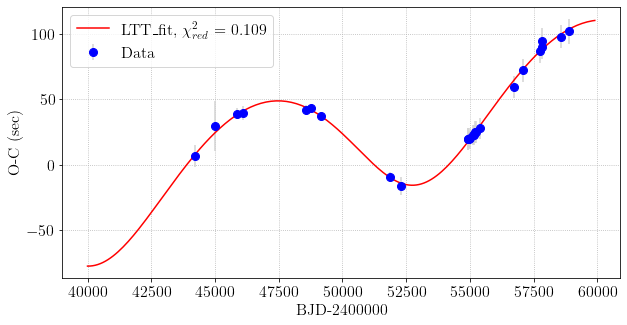

In [16]:
#Plotgraph
fig=plt.figure(figsize=(10, 5))
plt.errorbar(x, y, yerr= dy, fmt='o', markersize=8, color='blue', ecolor='lightgray',label='Data')
# create a line plot for the mapping function
plt.plot(x_range, y_range, '-', color='red',label='LTT\_fit, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq)))
#plt.plot(BJD_time, OC_s_ecc, lw=2, color='black')
#plt.xlim(-6000,6000)
#plt.ylim(-200,200)
#plt.ylim(-40,60)
plt.xlabel('BJD-'+str(N_BMJD))
plt.ylabel('O-C (sec)')
plt.grid(linestyle='dotted')
plt.legend(loc="best")
#####plt.title('O-C diagram: DP Leo')
#output_filename = os.path.splitext(__file__)[0] + '.png'
#plt.savefig("DP_Leo_LTT_fit_Demo.jpg", dpi=1000)
plt.show()

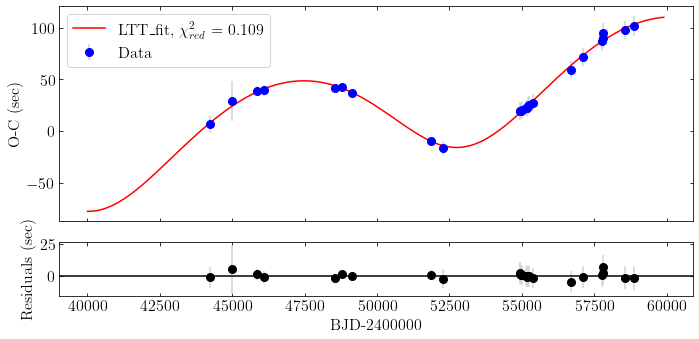

In [17]:
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, sharex=True, sharey=False, figsize=(10, 5), tight_layout=True)
plt.xlabel('BJD-'+str(N_BMJD))

ax0.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')
ax1.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')

ax0.errorbar(x, y, yerr= dy, fmt='o', markersize=8, color='blue', ecolor='lightgray',label='Data')
ax0.plot(x_range, y_range, '-', color='red',label='LTT\_fit, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq)))

ax0.set_ylabel('O-C (sec)')
ax0.legend(loc="best")

Residual = y-ocfit

ax1.set_ylabel('Residuals (sec)')
ax1.errorbar(x, Residual, yerr= dy, fmt='o', markersize=8, color='black', ecolor='lightgray')
ax1.axhline(y=0, color='black', linestyle='-')

plt.savefig("DP_Leo_LTT_fit_weighted_data_Beuermann_2011_Indirect_Linear_Res.jpg", dpi=1000)

plt.show()

In [18]:
print("-------------------------------------------------")
print("Parameters derived from the eccentric orbit fit")
print("-------------------------------------------------")
print("(a) Binary DP Leo ab:")
print("Epoch (T0) =", '%0.5f' %(T), "+/-", '%0.5f' %(dT), "[days]")
print("Binary period (P_bin) =", '%0.10f' %(Period), "+/-", '%0.10f' %(dPeriod), "[days]")
print("(b) Giant planet DP Leo (ab)c:")
print("Orbital period (P_yr) =", '%0.1f' %(P/365.25), "+/-", '%0.1f' %((dP**0.5)/365.25), "[years]")
print ("Semi-major axis (a) =", '%0.2f' %(a_au) ,'+/-', '%0.2f' %(da_au), '[AU]')
print("Eccentricity (e) =", '%0.2f' %(e), "+/-", '%0.2f' %(de**0.5), "[-]")
print("Longitude of periastron (w_deg) =", '%0.0f' %(w*(180/np.pi)), "+/-", '%0.0f' %(dw**0.5*(180/np.pi)), "[deg]")
print("Time of periastron passage (tau) =", '%0.0f' %(tau), "+/-", '%0.0f' %(dtau**0.5), "[days]")
print("Amplitude of the LTT effect (K) =", '%0.1f' %(K), "+/-", '%0.1f' %(dK**0.5), "[s]")

-------------------------------------------------
Parameters derived from the eccentric orbit fit
-------------------------------------------------
(a) Binary DP Leo ab:
Epoch (T0) = 2448773.21510 +/- 0.00006 [days]
Binary period (P_bin) = 0.0623628404 +/- 0.0000000007 [days]
(b) Giant planet DP Leo (ab)c:
Orbital period (P_yr) = 34.8 +/- 1.0 [years]
Semi-major axis (a) = 10.67 +/- 0.20 [AU]
Eccentricity (e) = 0.18 +/- 0.06 [-]
Longitude of periastron (w_deg) = -107 +/- 17 [deg]
Time of periastron passage (tau) = 52544 +/- 576 [days]
Amplitude of the LTT effect (K) = 46.2 +/- 1.1 [s]


#### The changing parameters: w = -2

In [19]:
m = 0.0003033322646783796
c = 2.3894443740629105
K = 46.2     
P = 12722    
e = 0.18             
w_fixed = -2         
tau = 52544 

In [20]:
def keplerian_fit_a(t,w_fixed):
    f = TAno(P,tau,e,t)
    Epoch = (t-BJD0)/P0
    return m*Epoch + c + K*((1-e*e)/(1+e*np.cos(f))*np.sin(f+w_fixed))

In [21]:
params_a, params_covariance_a = curve_fit(lambda x, w_fixed: keplerian_fit_a(x, w_fixed), x, y)
ocfit_a = keplerian_fit_a(x,*params_a)

x_min, x_max = np.amin(x), np.amax(x)
x_line_a = np.linspace(x_min, x_max)
y_line_a = keplerian_fit_a(x_line_a, *params_a) #### For all interporation 
#print(y_line)
#print(ocfit)
#print(x)

#Reduced_chisqrt
n = 1
dof = len_x - n
Chi_sqr = ((y - ocfit_a)**2/(dy)**2)/dof
Reduced_chisq_a = sum(Chi_sqr)
print("Reduced_chisq:",Reduced_chisq_a)

Reduced_chisq: 0.08340627466985577


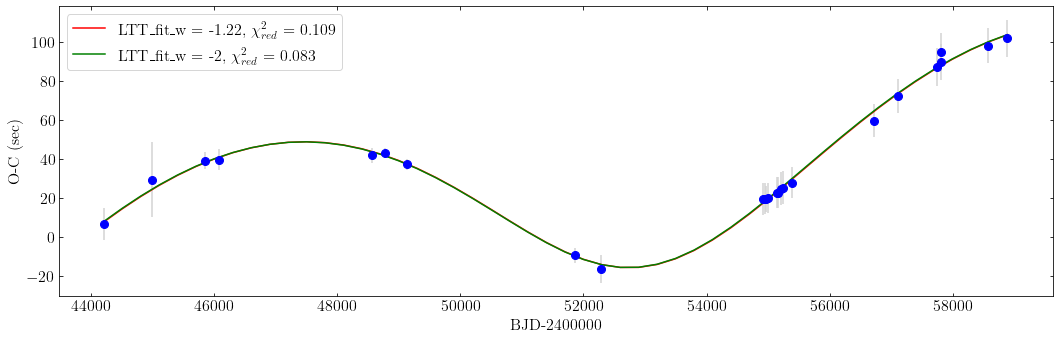

In [22]:
N_BMJD = 2400000
#print(phase)
#fig,ax = plt.subplots()
fig=plt.figure(figsize=(15, 5), tight_layout=True)
plt.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')
#plt.errorbar(x,y,dy,fmt='ok')
plt.errorbar(x, y, yerr= dy, fmt='o', markersize=8, color='blue', ecolor='lightgray')
plt.plot(x_line,y_line,'-r',label='LTT\_fit\_w = -1.22, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq)))
plt.plot(x_line_a,y_line_a,'-g',label='LTT\_fit\_w = -2, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq_a)))
#plt.title('phased RV data for 51 Peg b')
plt.xlabel('BJD-'+str(N_BMJD))
plt.ylabel('O-C (sec)')
plt.legend(loc="best")
plt.show()

#### The changing parameters: w = -1

In [23]:
m = 0.0003033322646783796
c = 2.3894443740629105
K = 46.2     
P = 12722    
e = 0.18             
w_fixed = -1         
tau = 52544 

In [24]:
def keplerian_fit_b(t,w_fixed):
    f = TAno(P,tau,e,t)
    Epoch = (t-BJD0)/P0
    return m*Epoch + c + K*((1-e*e)/(1+e*np.cos(f))*np.sin(f+w_fixed))

In [25]:
params_b, params_covariance_b = curve_fit(lambda x, w_fixed: keplerian_fit_b(x, w_fixed), x, y)
#print(w_fixed)
ocfit_b = keplerian_fit_b(x,*params_b)

x_min, x_max = np.amin(x), np.amax(x)
x_line_b = np.linspace(x_min, x_max)
y_line_b = keplerian_fit_b(x_line_b, *params_b) #### For all interporation 
#print(y_line)
#print(ocfit)
#print(x)

#Reduced_chisqrt
n = 1
dof = len_x - n
Chi_sqr = ((y - ocfit_b)**2/(dy)**2)/dof
Reduced_chisq_b = sum(Chi_sqr)
print("Reduced_chisq:",Reduced_chisq_b)

Reduced_chisq: 0.08340627466985577


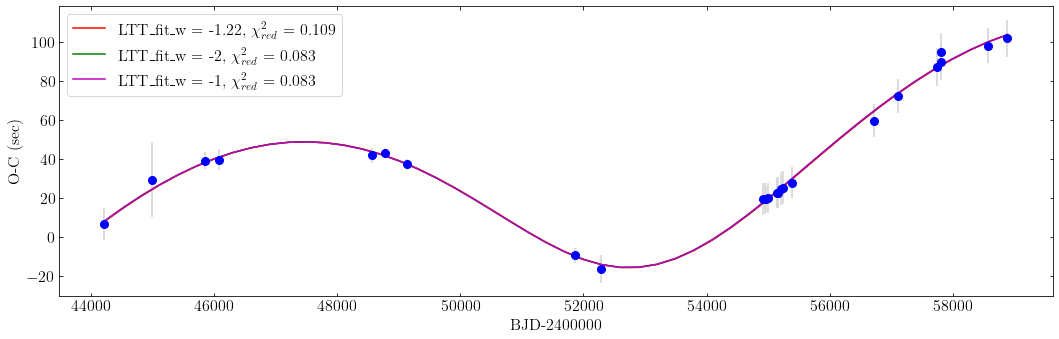

In [26]:
N_BMJD = 2400000
#print(phase)
#fig,ax = plt.subplots()
fig=plt.figure(figsize=(15, 5), tight_layout=True)
plt.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')
#plt.errorbar(x,y,dy,fmt='ok')
plt.errorbar(x, y, yerr= dy, fmt='o', markersize=8, color='blue', ecolor='lightgray')
plt.plot(x_line,y_line,'-r',label='LTT\_fit\_w = -1.22, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq)))
plt.plot(x_line_a,y_line_a,'-g',label='LTT\_fit\_w = -2, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq_a)))
plt.plot(x_line_b,y_line_b,'-m',label='LTT\_fit\_w = -1, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq_b)))
#plt.title('phased RV data for 51 Peg b')
plt.xlabel('BJD-'+str(N_BMJD))
plt.ylabel('O-C (sec)')
plt.legend(loc="best")
plt.show()

#### The changing parameters: w = 0

In [27]:
m = 0.0003033322646783796
c = 2.3894443740629105
K = 46.2     
P = 12722    
e = 0.18             
w_fixed = 0         
tau = 52544 

In [28]:
def keplerian_fit_c(t,w_fixed):
    f = TAno(P,tau,e,t)
    Epoch = (t-BJD0)/P0
    return m*Epoch + c + K*((1-e*e)/(1+e*np.cos(f))*np.sin(f+w_fixed))

In [29]:
params_c, params_covariance_c = curve_fit(lambda x, w_fixed: keplerian_fit_c(x, w_fixed), x, y)
#print(w_fixed)
ocfit_c = keplerian_fit_c(x,*params_c)

x_min, x_max = np.amin(x), np.amax(x)
x_line_c = np.linspace(x_min, x_max)
y_line_c = keplerian_fit_c(x_line_c, *params_c) #### For all interporation 
#print(y_line)
#print(ocfit)
#print(x)

#Reduced_chisqrt
n = 1
dof = len_x - n
Chi_sqr = ((y - ocfit_c)**2/(dy)**2)/dof
Reduced_chisq_c = sum(Chi_sqr)
print("Reduced_chisq:",Reduced_chisq_c)

Reduced_chisq: 0.08340627466985577


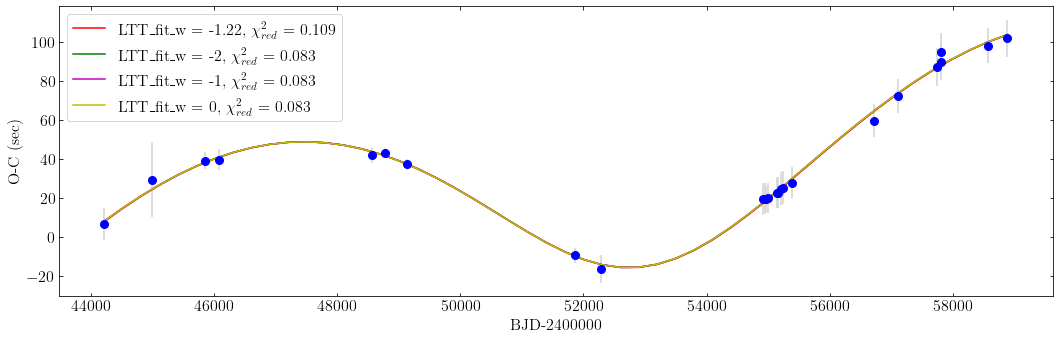

In [30]:
N_BMJD = 2400000
#print(phase)
#fig,ax = plt.subplots()
fig=plt.figure(figsize=(15, 5), tight_layout=True)
plt.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')
#plt.errorbar(x,y,dy,fmt='ok')
plt.errorbar(x, y, yerr= dy, fmt='o', markersize=8, color='blue', ecolor='lightgray')
plt.plot(x_line,y_line,'-r',label='LTT\_fit\_w = -1.22, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq)))
plt.plot(x_line_a,y_line_a,'-g',label='LTT\_fit\_w = -2, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq_a)))
plt.plot(x_line_b,y_line_b,'-m',label='LTT\_fit\_w = -1, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq_b)))
plt.plot(x_line_c,y_line_c,'-y',label='LTT\_fit\_w = 0, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq_c)))
#plt.title('phased RV data for 51 Peg b')
plt.xlabel('BJD-'+str(N_BMJD))
plt.ylabel('O-C (sec)')
plt.legend(loc="best")
plt.show()

#### The changing parameters: w = 1

In [31]:
m = 0.0003033322646783796
c = 2.3894443740629105
K = 46.2     
P = 12722    
e = 0.18             
w_fixed = 1         
tau = 52544 

In [32]:
def keplerian_fit_d(t,w_fixed):
    f = TAno(P,tau,e,t)
    Epoch = (t-BJD0)/P0
    return m*Epoch + c + K*((1-e*e)/(1+e*np.cos(f))*np.sin(f+w_fixed))

In [33]:
params_d, params_covariance_d = curve_fit(lambda x, w_fixed: keplerian_fit_d(x, w_fixed), x, y)
#print(w_fixed)
ocfit_d = keplerian_fit_d(x,*params_d)

x_min, x_max = np.amin(x), np.amax(x)
x_line_d = np.linspace(x_min, x_max)
y_line_d = keplerian_fit_d(x_line_d, *params_d) #### For all interporation 
#print(y_line)
#print(ocfit)
#print(x)

#Reduced_chisqrt
n = 1
dof = len_x - n
Chi_sqr = ((y - ocfit_d)**2/(dy)**2)/dof
Reduced_chisq_d = sum(Chi_sqr)
print("Reduced_chisq:",Reduced_chisq_d)

Reduced_chisq: 0.08340627466985577


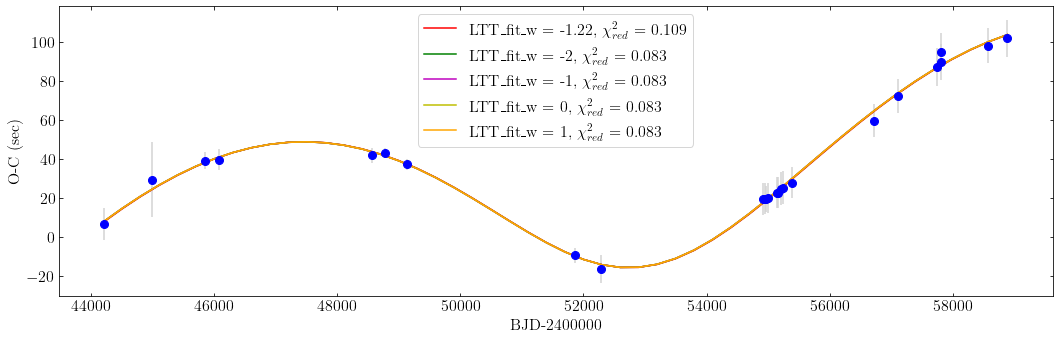

In [34]:
N_BMJD = 2400000
#print(phase)
#fig,ax = plt.subplots()
fig=plt.figure(figsize=(15, 5), tight_layout=True)
plt.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')
#plt.errorbar(x,y,dy,fmt='ok')
plt.errorbar(x, y, yerr= dy, fmt='o', markersize=8, color='blue', ecolor='lightgray')
plt.plot(x_line,y_line,'-r',label='LTT\_fit\_w = -1.22, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq)))
plt.plot(x_line_a,y_line_a,'-g',label='LTT\_fit\_w = -2, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq_a)))
plt.plot(x_line_b,y_line_b,'-m',label='LTT\_fit\_w = -1, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq_b)))
plt.plot(x_line_c,y_line_c,'-y',label='LTT\_fit\_w = 0, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq_c)))
plt.plot(x_line_d,y_line_d,'orange',label='LTT\_fit\_w = 1, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq_d)))
#plt.title('phased RV data for 51 Peg b')
plt.xlabel('BJD-'+str(N_BMJD))
plt.ylabel('O-C (sec)')
plt.legend(loc="best")
plt.show()

#### The changing parameters: w = 2

In [35]:
m = 0.0003033322646783796
c = 2.3894443740629105
K = 46.2     
P = 12722    
e = 0.18             
w_fixed = 2         
tau = 52544 

In [36]:
def keplerian_fit_e(t,w_fixed):
    f = TAno(P,tau,e,t)
    Epoch = (t-BJD0)/P0
    return m*Epoch + c + K*((1-e*e)/(1+e*np.cos(f))*np.sin(f+w_fixed))

In [37]:
params_e, params_covariance_e = curve_fit(lambda x, w_fixed: keplerian_fit_e(x, w_fixed), x, y)
#print(w_fixed)
ocfit_e = keplerian_fit_e(x,*params_e)

x_min, x_max = np.amin(x), np.amax(x)
x_line_e = np.linspace(x_min, x_max)
y_line_e = keplerian_fit_e(x_line_e, *params_e) #### For all interporation 
#print(y_line)
#print(ocfit)
#print(x)

#Reduced_chisqrt
n = 1
dof = len_x - n
Chi_sqr = ((y - ocfit_e)**2/(dy)**2)/dof
Reduced_chisq_e = sum(Chi_sqr)
print("Reduced_chisq:",Reduced_chisq_e)

Reduced_chisq: 0.08340627466985577


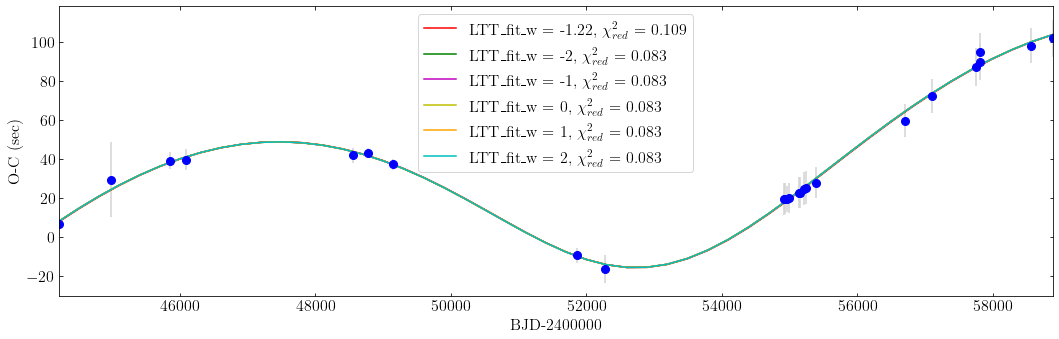

In [38]:
N_BMJD = 2400000
#print(phase)
#fig,ax = plt.subplots()
fig=plt.figure(figsize=(15, 5), tight_layout=True)
plt.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')
#plt.errorbar(x,y,dy,fmt='ok')
plt.errorbar(x, y, yerr= dy, fmt='o', markersize=8, color='blue', ecolor='lightgray')
plt.plot(x_line,y_line,'-r',label='LTT\_fit\_w = -1.22, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq)))
plt.plot(x_line_a,y_line_a,'-g',label='LTT\_fit\_w = -2, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq_a)))
plt.plot(x_line_b,y_line_b,'-m',label='LTT\_fit\_w = -1, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq_b)))
plt.plot(x_line_c,y_line_c,'-y',label='LTT\_fit\_w = 0, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq_c)))
plt.plot(x_line_d,y_line_d,'orange',label='LTT\_fit\_w = 1, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq_d)))
plt.plot(x_line_e,y_line_e,'-c',label='LTT\_fit\_w = 2, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq_e)))
plt.xlim(x_line[0],x_line[-1])
plt.xlabel('BJD-'+str(N_BMJD))
plt.ylabel('O-C (sec)')
plt.legend(loc="best")
plt.savefig("DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_w1.pdf", format='pdf', dpi=1200)
plt.show()

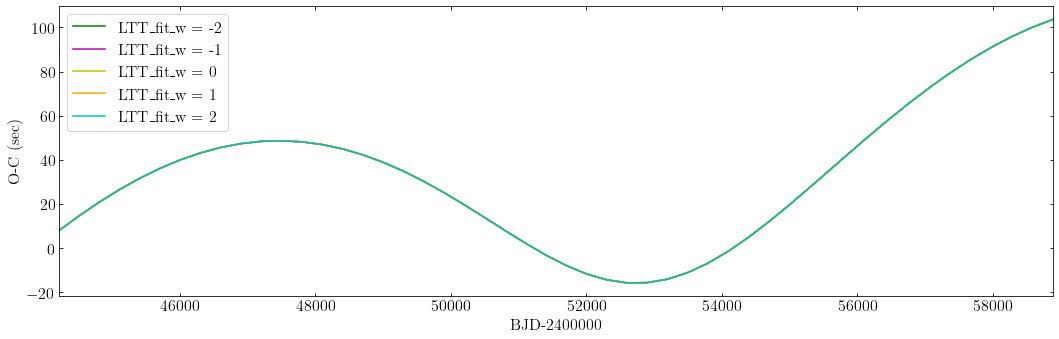

In [39]:
N_BMJD = 2400000
#print(phase)
#fig,ax = plt.subplots()
fig=plt.figure(figsize=(15, 5), tight_layout=True)
plt.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')
#plt.errorbar(x,y,dy,fmt='ok')
#plt.errorbar(x, y, yerr= dy, fmt='o', markersize=8, color='blue', ecolor='lightgray')
#plt.plot(x_line,y_line,'-r',label='LTT\_fit\_w = -1.22, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq)))
plt.plot(x_line_a,y_line_a,'-g',label='LTT\_fit\_w = -2')
plt.plot(x_line_b,y_line_b,'-m',label='LTT\_fit\_w = -1')
plt.plot(x_line_c,y_line_c,'-y',label='LTT\_fit\_w = 0')
plt.plot(x_line_d,y_line_d,'orange',label='LTT\_fit\_w = 1')
plt.plot(x_line_e,y_line_e,'-c',label='LTT\_fit\_w = 2')
plt.xlim(x_line[0],x_line[-1])
plt.xlabel('BJD-'+str(N_BMJD))
plt.ylabel('O-C (sec)')
plt.legend(loc="best")
plt.savefig("DP_Leo_LTT_fit_Indirect_Linear_parameter_changes_w2.pdf", format='pdf', dpi=1200)
plt.show()